# Crude Measure of COVID-19 Response by Country (as of Oct 12)
### I will measure the ratio of each country's percentage of global population and global COVID-19 deaths.
That ratio is 1 for a country whose share of global COVID-19 deaths is the same as the share of that country's global population. This ratio offers a crude measure of each country's response to COVID-19.

Inspired by this tweet https://twitter.com/ZachWahls/status/1309485996615106563/photo/1

#### Data: https://www.worldometers.info/world-population/population-by-country/ and 2019 GDP estimates from IMF

In [285]:
using CSV
using DataFrames
using Plots
using StatsPlots
pyplot()

Plots.PyPlotBackend()

In [395]:
global_deaths = 1_084_149; #from 

In [396]:
IMF_GDP_2019 = CSV.read("IMF_GDP_2019.csv")
select!(IMF_GDP_2019, [:1, :6])
rename!(IMF_GDP_2019, ["country_name", "GDP_USD_Billions"]);

In [397]:
original_population = CSV.read("COVID_metrics_population.csv");

In [398]:
# only retain Country Name, Population, and World Share
clean_population = select(original_population, [:2, :3, :12]);
rename!(clean_population, ["country_name", "pop", "percent_world_pop"]);

In [399]:
original_deaths = CSV.read("COVID_metrics_deaths.csv");

thread = 1 warning: only found 13 / 14 columns around data row: 218. Filling remaining columns with `missing`
thread = 1 warning: only found 13 / 14 columns around data row: 218. Filling remaining columns with `missing`


In [400]:
# only retain Country Name, Total Cases, Total Deaths, Total Tests
clean_deaths = select(original_deaths, [:2, :3, :5, :12]);
rename!(clean_deaths, ["country_name", "total_cases", "total_deaths", "total_tests"]);

In [401]:
# merge dataframes on country_name, drop missing
merged_df = join(clean_population, clean_deaths, kind = :outer, on = "country_name");
merged_df = join(merged_df, IMF_GDP_2019, kind = :outer, on = "country_name");
dropmissing!(merged_df);

In [402]:
# change column types from string to int or float
merged_df.pop = [parse(Int, x) for x in replace.(merged_df.pop, Ref(","=>""))];
merged_df.percent_world_pop = [parse(Float64, x) for x in replace.(merged_df.percent_world_pop, Ref(" %"=>""))]
merged_df.total_cases = [parse(Int, x) for x in replace.(merged_df.total_cases, Ref(","=>""))];
merged_df.total_deaths = [parse(Int, x) for x in replace.(merged_df.total_deaths, Ref(","=>""))];
merged_df.total_tests = [parse(Int, x) for x in replace.(merged_df.total_tests, Ref(","=>""))];
merged_df.GDP_USD_Billions = [parse(Float64, x) for x in replace.(merged_df.GDP_USD_Billions, Ref(","=>""))];

In [403]:
# drop rows where percent_world_pop is 0.0
merged_df = merged_df[merged_df[:percent_world_pop].!=0.0,:];

In [404]:
# create new column: percent_world_deaths
merged_df[:percent_world_deaths] = [round(x, digits = 5) for x in merged_df.total_deaths./global_deaths*100];

In [405]:
# create new column: deaths_pop_ratio
merged_df[:deaths_pop_ratio] = [round(x, digits=4) for x in merged_df.percent_world_deaths./merged_df.percent_world_pop];

In [422]:
# export cleaned dataframe as COVID_metrics_cleaned.csv
#CSV.write("COVID_metrics_cleaned.csv", merged_df)

In [410]:
df = CSV.read("COVID_metrics_cleaned.csv");

In [442]:
# sort list of 30 richest countries from high deaths_pop_ratio to low
sort!(df, :GDP_USD_Billions , rev=true);
graph = sort(head(df, 30), :deaths_pop_ratio);

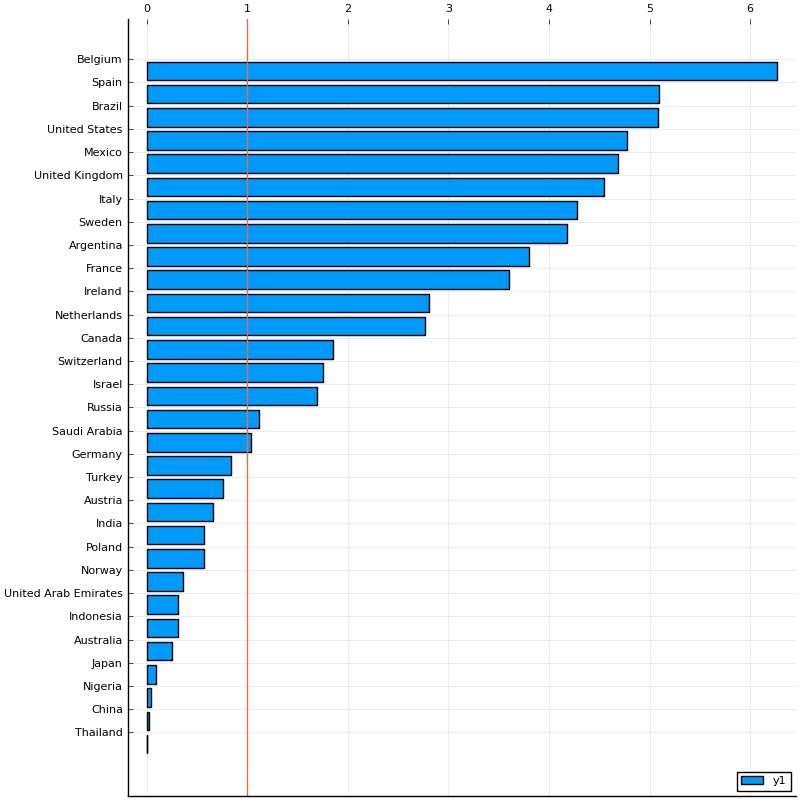

In [439]:
@df graph bar(:country_name, :deaths_pop_ratio, orientation = :horizontal, yticks = (1:size(graph)[1], graph.country_name), xmirror=true, legend=:bottomright)
plot!([1], seriestype="vline", label="")
plot!(size=(800, 800))

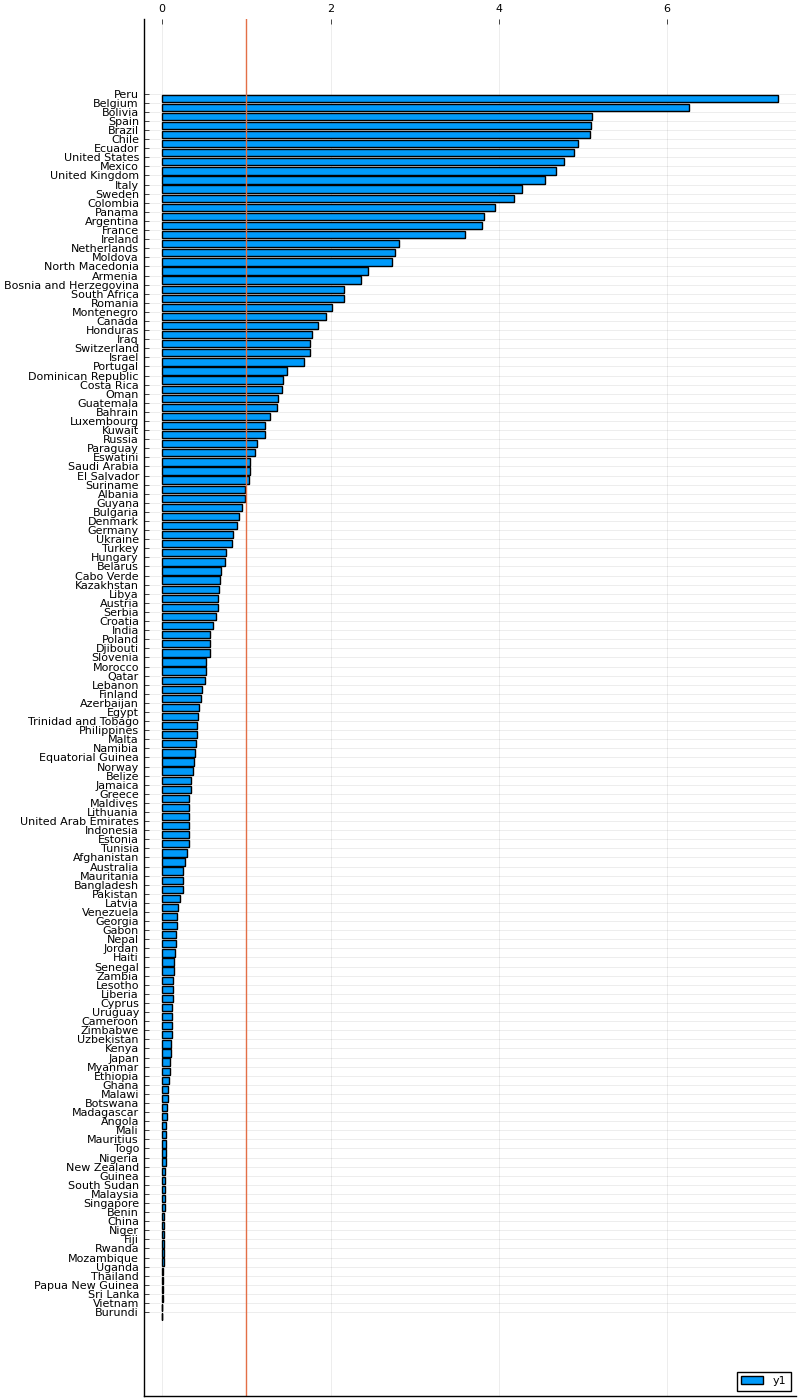

In [454]:
cat = sort(df, :deaths_pop_ratio);
@df cat bar(:country_name, :deaths_pop_ratio, orientation = :horizontal, yticks = (1:size(cat)[1], cat.country_name), xmirror=true, legend=:bottomright)
plot!([1], seriestype="vline", label="")
plot!(size=(800, 1400))